In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [4]:
# Step 3: Load data
df = pd.read_csv('Dementia Prediction Dataset.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_10336\4293451960.py:2: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Dementia Prediction Dataset.csv')


In [5]:
# Calculate age (approximate)
df['AGE'] = df['VISITYR'] - df['BIRTHYR']

In [6]:
# Select features and target
features = [
    'AGE', 'SEX', 'HISPANIC', 'RACE', 'EDUC', 'MARISTAT', 'INDEPEND', 'RESIDENC', 'HANDED',
    'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ',
    'NACCLIVS', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY',
    'NACCFAM', 'NACCMOM', 'NACCDAD',
    'CVHATT', 'HATTMULT', 'CVAFIB', 'CVANGIO', 'CVBYPASS', 'CVPACDEF', 'CVCHF', 'CVANGINA', 'CVHVALVE',
    'CBSTROKE', 'STROKMUL', 'CBTIA', 'TIAMULT', 'PD', 'SEIZURES', 'TBI', 'TBIBRIEF', 'TBIEXTEN', 'TBIWOLOS',
    'DIABETES', 'HYPERTEN', 'HYPERCHO', 'THYROID', 'ARTHRIT', 'INCONTU', 'INCONTF', 'APNEA',
    'ALCOHOL', 'ABUSOTHR', 'PTSD', 'BIPOLAR', 'SCHIZ', 'ANXIETY', 'DEP2YRS',
    'HEIGHT', 'WEIGHT', 'VISION', 'HEARING'
]
target = 'DEMENTED'

# Filter dataframe
df = df[features + [target]].dropna(subset=[target])  # Drop rows missing target

In [7]:
# Handle special missing codes (common in NACC: -4, 8, 88, 888, 8888, 9, 99, 999, etc.)
missing_codes = [-4, 8, 9, 88, 99, 888, 999, 8888, 9999]
for col in df.columns:
    df[col] = df[col].replace(missing_codes, np.nan)

# Identify categorical and numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target)
categorical_cols = ['SEX', 'HISPANIC', 'RACE', 'MARISTAT', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCLIVS', 'INLIVWTH']

# Preprocessing pipeline
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [8]:
# Step 4: Split data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

In [10]:
# Train
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of dementia (risk %)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f'Accuracy: {accuracy:.2f}')
print(f'ROC-AUC: {auc:.2f}')

Accuracy: 0.91
ROC-AUC: 0.95


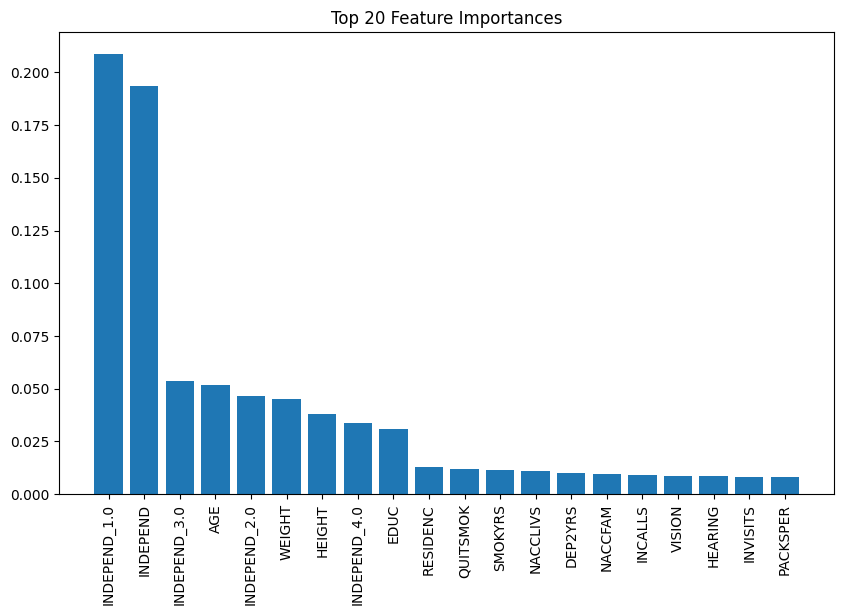

In [12]:
# Step 5: Feature Importance
importances = model.named_steps['classifier'].feature_importances_
# Get feature names after one-hot (approximate, for illustration)
feature_names = numerical_cols.tolist() + list(model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols))
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.show()